<a href="https://colab.research.google.com/github/tamahhamat/AI-project/blob/main/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
pip install scikit-learn

In [8]:
from google.colab import drive, data_table
import os
import pandas as pd
import numpy as np
import re



In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [9]:
# connect to google drive

from google.colab import drive
drive.mount('/content/drive')

# Set the path folder
PED_data_path = '/content/drive/MyDrive/AIdata/PED'

# Enable data table display for Pandas dataframes
data_table.enable_dataframe_formatter()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data**

**Demographics**

In [10]:
# Create an empty dataframe
columns = ["Participant", 'playedBefore', 'timePlaying', 'play', 'age', 'sex', 'country']
participant_df = pd.DataFrame(columns=columns)

# Iterate through participant folders
for participant_folder in os.listdir(PED_data_path):
    participant_path = os.path.join(PED_data_path, participant_folder)

    # Check if it's a directory
    if os.path.isdir(participant_path):
        # Get the list of files in the participant folder
        files_list = os.listdir(participant_path)

        # Initialize variables for additional information
        played_before = None
        time_playing = None
        play = None
        age = None
        sex = None
        country = None

        # Check if 'Dem.csv' file exists in the folder
        dem_file_path = os.path.join(participant_path, 'Dem.csv')
        if os.path.exists(dem_file_path):
            # Read the 'Dem.csv' file
            dem_df = pd.read_csv(dem_file_path, header=None, names=['A', 'B', 'C', 'D', 'E', 'F'])

            # Extract data from the dataframe
            row_data = dem_df.iloc[0]
            played_before = int(row_data['A'])
            time_playing = int(row_data['B'])
            play = int(row_data['C'])
            age = int(row_data['D'])
            sex = int(row_data['E'])
            country = row_data['F']

        # Add the folder name, file count,etc information to the dataframe
        new_row = pd.DataFrame({
            "Participant": [participant_folder],
            'playedBefore': [played_before],
            'timePlaying': [time_playing],
            'play': [play],
            'age': [age],
            'sex': [sex],
            'country': [country]
        })

        participant_df = pd.concat([participant_df, new_row], ignore_index=True)

# # Display the participant dataframe
# display(participant_df)

# Pivot the dataframe
pivoted_df = participant_df.pivot_table(index='Participant', aggfunc='first')

# # Display the pivoted dataframe
# display(pivoted_df)

**Preferences**

In [11]:
# Combined tables

# Create an empty DataFrame for combined data
combined_prefs_df = pd.DataFrame()

# Iterate through participant folders
for participant_folder in os.listdir(PED_data_path):
    participant_path = os.path.join(PED_data_path, participant_folder)

    # Check if it's a directory
    if os.path.isdir(participant_path):
        # Get the 'Pref.csv' file path for each participant
        prefs_file_path = os.path.join(participant_path, 'Pref.csv')

        # Check if 'Pref.csv' file exists
        if os.path.exists(prefs_file_path):
            # Read the 'Pref.csv' file
            prefs_df_participant = pd.read_csv(prefs_file_path, header=None)

            prefs_df_participant = prefs_df_participant.iloc[:, :10]

            # Rename the columns
            prefs_df_participant.columns = ['Game #', 'Level A Engagement', 'Level A Frustration', 'Level A Challenge', 'Level B Engagement', 'Level B Frustration', 'Level B Challenge', 'Engagement Preferences', 'Frustration Preferences', 'Challenge Preferences']

            # Add a new column for participant folder name
            prefs_df_participant.insert(0, 'Participant', participant_folder)

            # add participant data to the combined DataFrame
            if not combined_prefs_df.empty:
                combined_prefs_df = pd.concat([combined_prefs_df, pd.DataFrame([[''] * len(prefs_df_participant.columns)], columns=prefs_df_participant.columns)], ignore_index=True)
            combined_prefs_df = pd.concat([combined_prefs_df, prefs_df_participant], ignore_index=True)

# # Display the combined DataFrame
# display(combined_prefs_df)

**Gameplay**

In [12]:
# Function to combine data for all games played by a player into a single DataFrame
def combine_player_data(participant_folder):
    # Construct path to the participant folder
    participant_folder_path = os.path.join(PED_data_path, participant_folder)

    # List all game play CSV files in the participant folder
    csv_files = [file for file in os.listdir(participant_folder_path) if file.endswith('_A.csv') or file.endswith('_B.csv')]

    # Initialize empty list to store DataFrames for each game
    dfs = []

    # Iterate over each CSV file in the participant folder
    for csv_file in csv_files:
        # Construct path to the CSV file
        csv_file_path = os.path.join(participant_folder_path, csv_file)

        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(csv_file_path, header=None, names=["time stamp", "action code"])
        except Exception as e:
            print(f"Error reading {csv_file_path}: {e}")
            continue

        # Replace NaN values with a placeholder
        df.fillna('NA', inplace=True)

        # get game number and level from the file name
        game_number, level = re.search(r'(\d+)_([AB])', csv_file).groups()

        # Add columns for player folder name, game file name, game number, level, and attempt number
        df['Participant'] = participant_folder
        df['Game'] = csv_file
        df['GameNumber'] = int(game_number)
        df['Level'] = level
        df['Attempt'] = (df['action code'].astype(str).str.lower().str.contains('level_start')).cumsum()

        # add the DataFrame to the list
        dfs.append(df)

    # combine all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Reorder columns
    combined_df = combined_df[['Participant', 'Game', 'GameNumber', 'Level', 'Attempt', 'time stamp', 'action code']]

    return combined_df

# List of participant folders
participant_folders = [
    'hec_22_03', 'nat_22_02', 'jul_23_03', 'par_16_03', 'jul_22_02', 'gog_10_03', 'jon_23_03', 'ili_07_12',
    'ele_07_12', 'gou_10_03', 'kat_16_03', 'mrn_22_02', 'pin_1_2', 'kar_14_03', 'des_22_02', 'kal_16_03',
    'jua_22_03', 'ema_14_02', 'ele_10_03', 'dar_22_03', 'ben_23_03', 'des_16_03', 'chr_22_03', 'ant_23_03',
    'asi_08_02', 'ama_16_03', '_teo_10_03', 'ril_22_02', 'kun_22_03', 'nel_1_2', 'mar_1_2', 'mar_23_03', 'nti_16_03',
    'dan-17-11', 'kal_08_02', 'mar_22_02', 'rik_22_02', 'ili_09_02', 'pen-17-11', 'leo_22_03', 'var_16_03', 'tro_22_03',
    '_jo2_23_03', '_em2_23_03', '_fot_14_03', 'yun_23_03', '_emi_23_03', 'cla_22_03', 'sta_10_03', 'tas_16_03',
    'sof_08_02', 'sig_22_02', '_dit_22_02', 'sar_10_03', 'the_08_02', 'ska_16_03', 'ste_04_03', 'sim_14_03', '_tol_11_03'
]

# create an empty list to store DataFrames for each participant
all_participant_dfs = []

# Iterate over each participant folder
for participant_folder in participant_folders:
    # Call the function to combine data for all games played by the participant
    combined_data = combine_player_data(participant_folder)

    # add the DataFrame to the list
    all_participant_dfs.append(combined_data)

# combine all DataFrames in the list into a single DataFrame for all participants
combined_all_participant_data = pd.concat(all_participant_dfs, ignore_index=True)

# # Display the combined DataFrame for all participants, games, and attempts
# display(combined_all_participant_data)

**Merged Data frames**

In [13]:
# Merge the dataframes on 'Participant' column
combined_data = pd.merge(pivoted_df, combined_prefs_df, on='Participant', how='inner')

# # Display the combined dataframe
# display(combined_data)


# **Decision Tree**

**Level A**

In [30]:
# Select columns for prediction
selected_features_a = ['age', 'sex', 'play', 'playedBefore', 'timePlaying', 'Level A Challenge', 'Level A Frustration']

target_variable_a = 'Level A Engagement'

# Select columns from the combined data
selected_data_a = combined_data[[target_variable_a] + selected_features_a].dropna()

# Convert to integers
selected_data_a[target_variable_a] = selected_data_a[target_variable_a].astype(int)

# Split the data into training and testing
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(selected_data_a[selected_features_a], selected_data_a[target_variable_a], test_size=0.2, random_state=42)

# Create a decision tree classifier
tree_classifier_a = DecisionTreeClassifier(random_state=42)

# Train
tree_classifier_a.fit(X_train_a, y_train_a)

# Make predictions
predictions_a = tree_classifier_a.predict(X_test_a)

# Evaluate
accuracy_a = accuracy_score(y_test_a, predictions_a)
report_a = classification_report(y_test_a, predictions_a)

print(f"Accuracy (Level A): {accuracy_a}")
print("Classification Report (Level A):")
print(report_a)




Accuracy (Level A): 0.7105263157894737
Classification Report (Level A):
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.81      0.76      0.79        17
           2       0.62      0.67      0.64        12
           3       0.50      0.50      0.50         2
           4       1.00      1.00      1.00         2

    accuracy                           0.71        38
   macro avg       0.71      0.71      0.71        38
weighted avg       0.72      0.71      0.71        38



Feature Importances for Level A:
               Feature  Importance
0                  age    0.363760
6  Level A Frustration    0.276015
5    Level A Challenge    0.171639
3         playedBefore    0.066421
4          timePlaying    0.054947
2                 play    0.036781
1                  sex    0.030437

Data Meaning:
- Age: The number represents the participant's age.
- Sex: 0=male, 1=female.
- Play: 0=yes, 1=no.
- Played Before: 0=yes, 1=no.
- Time Playing:
  - 0-2 hours per week: 0.
  - 2-5 hours per week: 1.
  - 5-10 hours per week: 2.
  - 10+ hours per week: 3.
- Level Challenge and Level Frustration Ranking Values:
  - 0: Extremely.
  - 1: Fairly.
  - 2: Moderately.
  - 3: Slightly.
  - 4: Not at all.



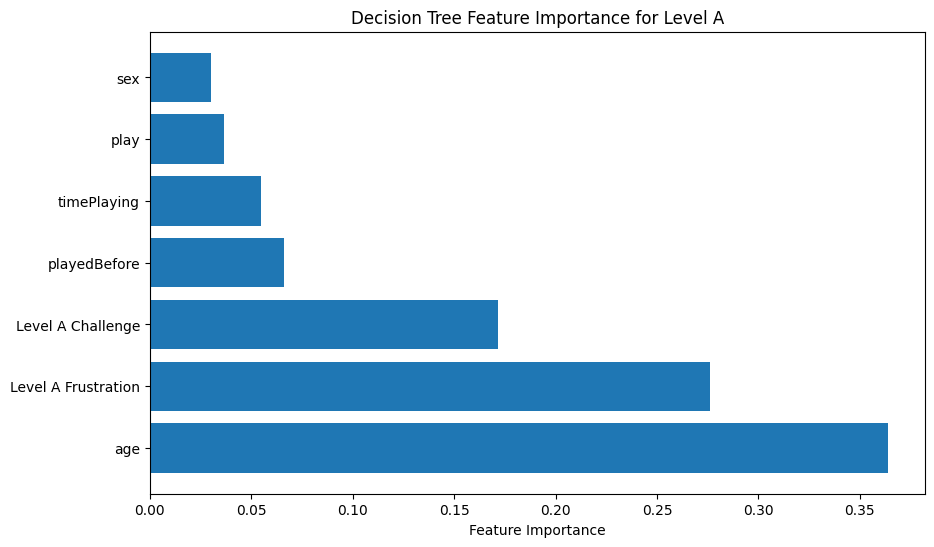

In [31]:
# Get feature importances
feature_importance_a = tree_classifier_a.feature_importances_

importance_df_a = pd.DataFrame({'Feature': selected_features_a, 'Importance': feature_importance_a})

# Sort the DataFrame by importance in descending order
importance_df_a = importance_df_a.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances for Level A:")
print(importance_df_a)

# data meaning
data_meaning = """
Data Meaning:
- Age: The number represents the participant's age.
- Sex: 0=male, 1=female.
- Play: 0=yes, 1=no.
- Played Before: 0=yes, 1=no.
- Time Playing:
  - 0-2 hours per week: 0.
  - 2-5 hours per week: 1.
  - 5-10 hours per week: 2.
  - 10+ hours per week: 3.
- Level Challenge and Level Frustration Ranking Values:
  - 0: Extremely.
  - 1: Fairly.
  - 2: Moderately.
  - 3: Slightly.
  - 4: Not at all.
"""

print(data_meaning)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_a['Feature'], importance_df_a['Importance'])
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance for Level A')
plt.show()

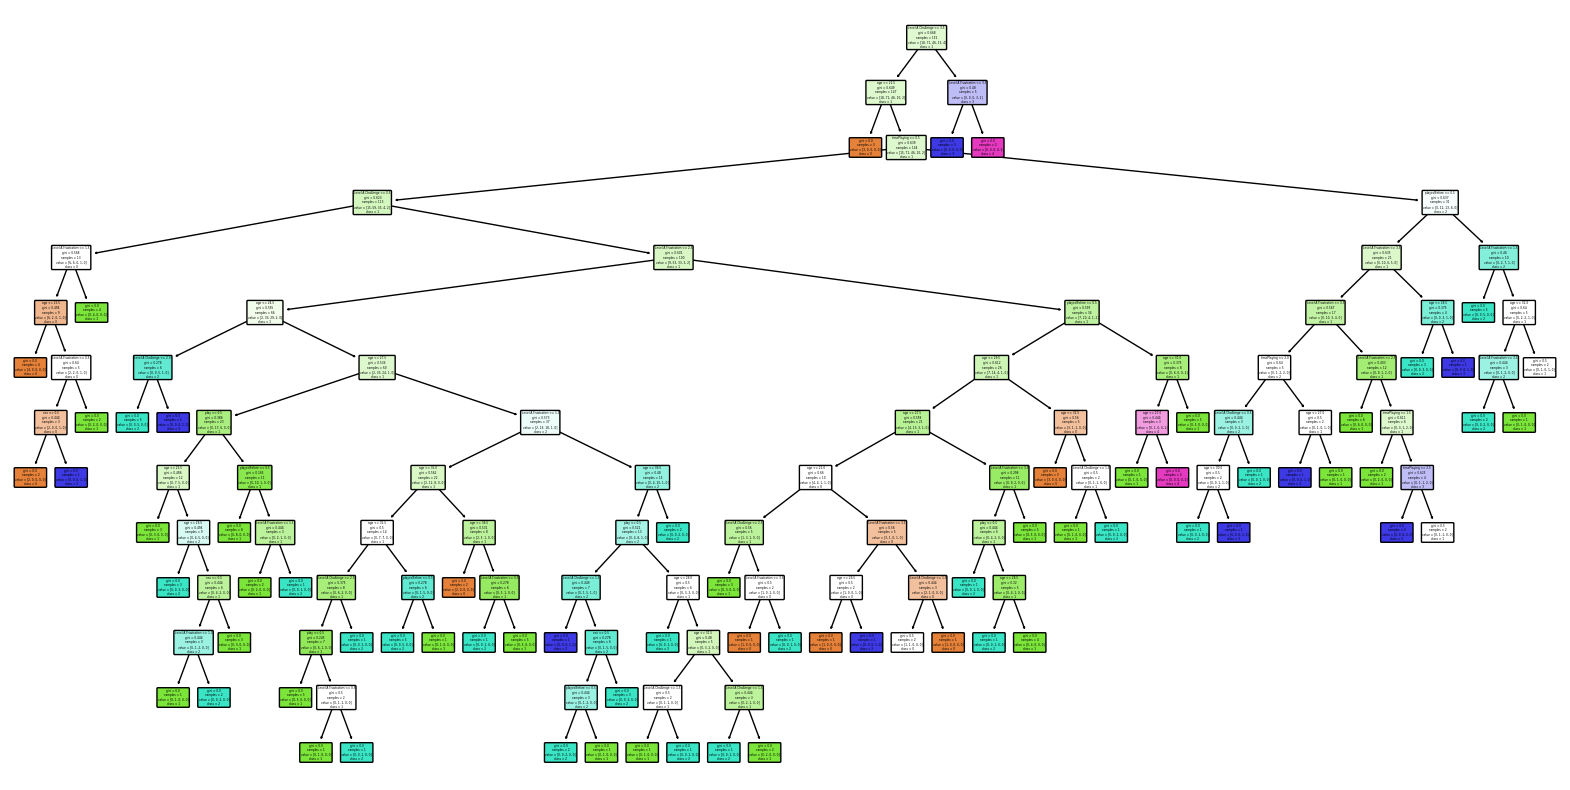

In [32]:
from sklearn.tree import plot_tree

# Create a decision tree classifier
tree_classifier_a = DecisionTreeClassifier(random_state=42)

# Train the model
tree_classifier_a.fit(X_train_a, y_train_a)

# show the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_classifier_a, feature_names=selected_features_a, class_names=[str(i) for i in range(5)], filled=True, rounded=True)
plt.show()

In [33]:
pip install shap

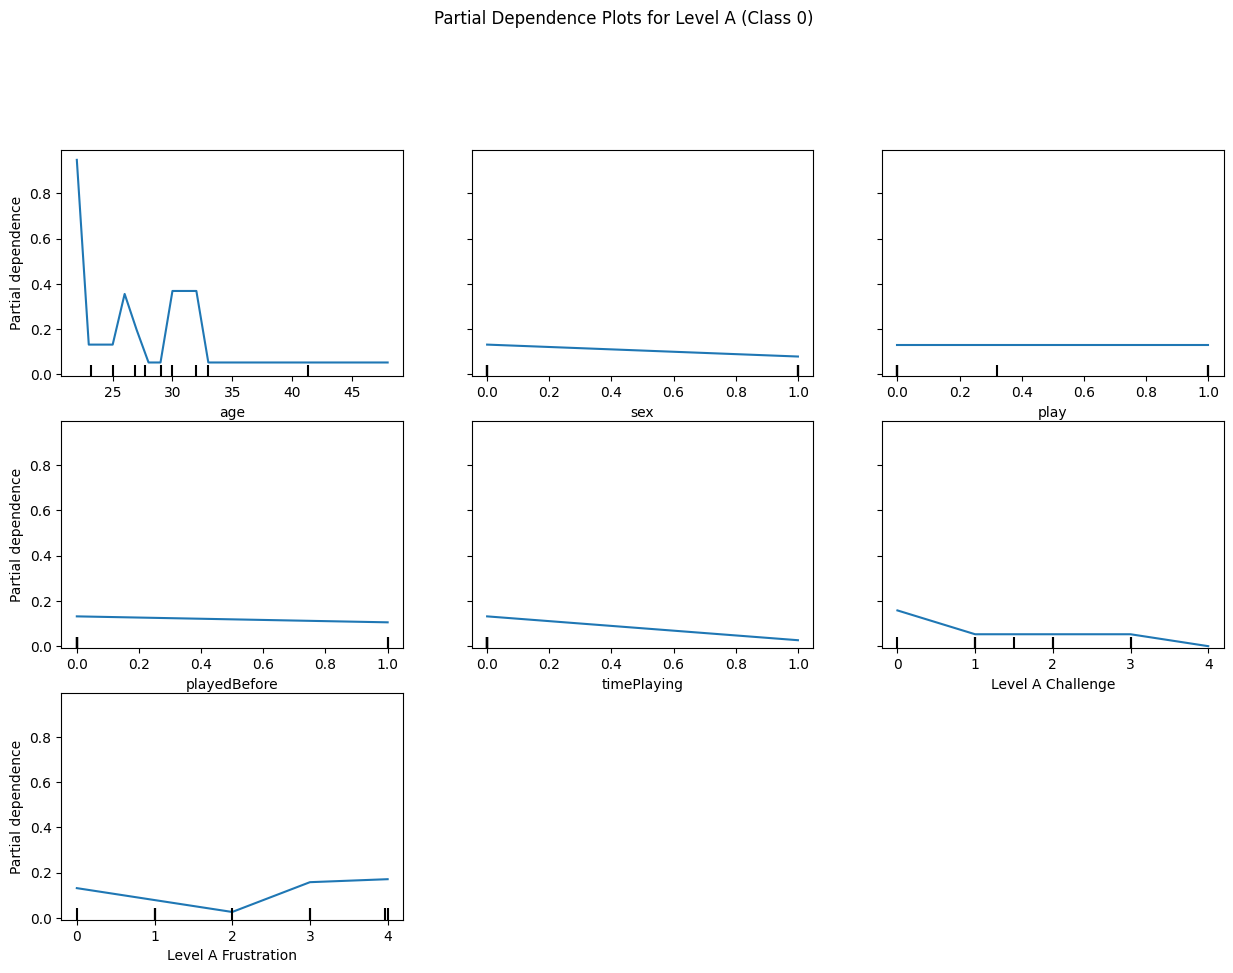

In [34]:
from sklearn.inspection import PartialDependenceDisplay

target_variable_a = 'Level A Engagement'

# Choose a target class
target_class = 0

# Create a decision tree classifier
tree_classifier_a = DecisionTreeClassifier(random_state=42)

# Train model
tree_classifier_a.fit(X_train_a, y_train_a)

# Create PartialDependenceDisplay for each feature
fig, ax = plt.subplots(figsize=(15, 10))
disp = PartialDependenceDisplay.from_estimator(
    tree_classifier_a, X_test_a, features=selected_features_a, ax=ax, target=target_class
)
disp.figure_.suptitle(f'Partial Dependence Plots for Level A (Class {target_class})', y=1.02)
plt.show()

**Level B**

In [35]:
# Select columns for prediction
selected_features_b = ['age', 'sex', 'play', 'playedBefore', 'timePlaying', 'Level B Challenge', 'Level B Frustration']

# Level B Engagement is the target variable
target_variable_b = 'Level B Engagement'

# Select columns from the combined data
selected_data_b = combined_data[[target_variable_b] + selected_features_b].dropna()

# Convert to integers
selected_data_b[target_variable_b] = selected_data_b[target_variable_b].astype(int)

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(selected_data_b[selected_features_b], selected_data_b[target_variable_b], test_size=0.2, random_state=42)

# Create a decision tree classifier
tree_classifier_b = DecisionTreeClassifier(random_state=42)

# Train the model
tree_classifier_b.fit(X_train_b, y_train_b)

# Make predictions on test set
predictions_b = tree_classifier_b.predict(X_test_b)

# Evaluate the model
accuracy_b = accuracy_score(y_test_b, predictions_b)
report_b = classification_report(y_test_b, predictions_b)

print(f"Accuracy (Level B): {accuracy_b}")
print("Classification Report (Level B):")
print(report_b)



Accuracy (Level B): 0.6578947368421053
Classification Report (Level B):
              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.69      0.65      0.67        17
           2       0.78      0.78      0.78         9
           3       0.50      0.50      0.50         2
           4       0.00      0.00      0.00         1

    accuracy                           0.66        38
   macro avg       0.50      0.52      0.51        38
weighted avg       0.65      0.66      0.65        38



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature Importances for Level B:
               Feature  Importance
0                  age    0.321722
6  Level B Frustration    0.216564
5    Level B Challenge    0.180598
4          timePlaying    0.109079
1                  sex    0.082620
2                 play    0.055868
3         playedBefore    0.033548

Data Meaning:
- Age: The number represents the participant's age.
- Sex: 0=male, 1=female.
- Play: 0=yes, 1=no.
- Played Before: 0=yes, 1=no.
- Time Playing:
  - 0-2 hours per week: 0.
  - 2-5 hours per week: 1.
  - 5-10 hours per week: 2.
  - 10+ hours per week: 3.
- Level B Challenge and Level B Frustration Ranking Values:
  - 0: Extremely.
  - 1: Fairly.
  - 2: Moderately.
  - 3: Slightly.
  - 4: Not at all.



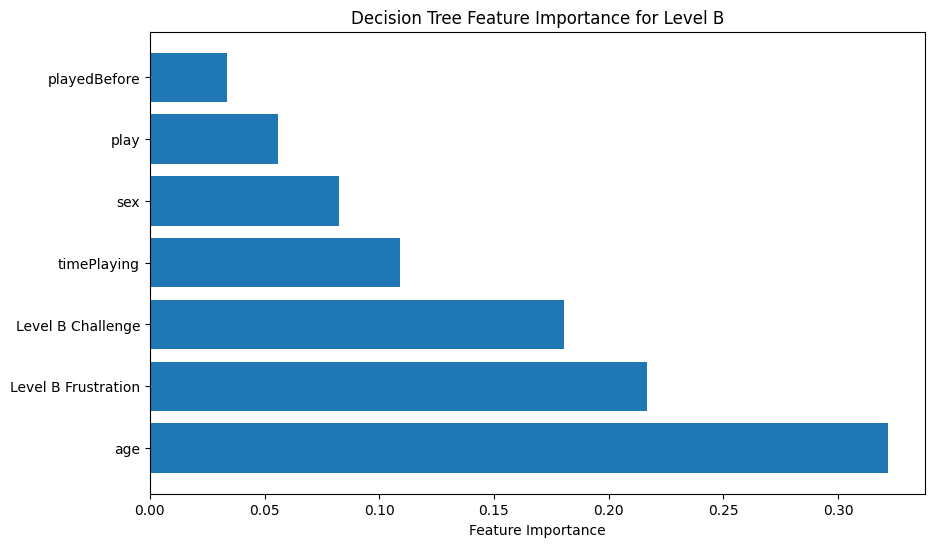

In [36]:
# Get feature importances
feature_importance_b = tree_classifier_b.feature_importances_

# Create a DataFrame
importance_df_b = pd.DataFrame({'Feature': selected_features_b, 'Importance': feature_importance_b})

# Sort the DataFrame by importance in descending order
importance_df_b = importance_df_b.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances for Level B:")
print(importance_df_b)

# Display the data meanings
data_meaning_b = """
Data Meaning:
- Age: The number represents the participant's age.
- Sex: 0=male, 1=female.
- Play: 0=yes, 1=no.
- Played Before: 0=yes, 1=no.
- Time Playing:
  - 0-2 hours per week: 0.
  - 2-5 hours per week: 1.
  - 5-10 hours per week: 2.
  - 10+ hours per week: 3.
- Level B Challenge and Level B Frustration Ranking Values:
  - 0: Extremely.
  - 1: Fairly.
  - 2: Moderately.
  - 3: Slightly.
  - 4: Not at all.
"""

print(data_meaning_b)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_b['Feature'], importance_df_b['Importance'])
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance for Level B')
plt.show()

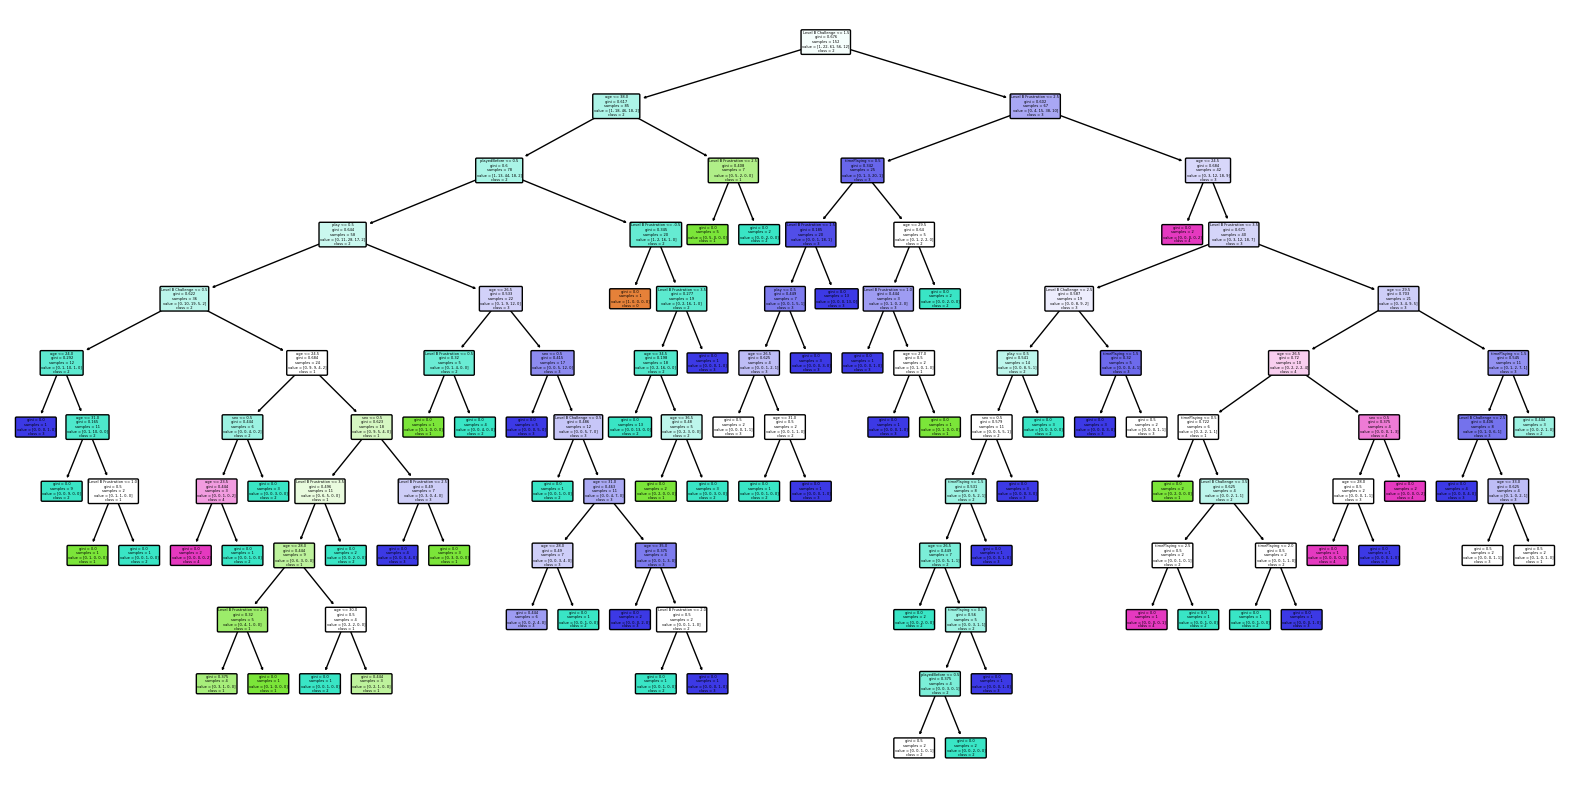

In [37]:
# Create a decision tree classifier
tree_classifier_b = DecisionTreeClassifier(random_state=42)

# Train the model
tree_classifier_b.fit(X_train_b, y_train_b)

# show the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_classifier_b, feature_names=selected_features_b, class_names=[str(i) for i in range(5)], filled=True, rounded=True)
plt.show()